# BFF Machine Learning
In this notebook, I'll test some machine learning (ML) algorithms on Brazilian Financial Funds. The inspiration is to create an algorithm able to forecast funds return so investor can plan and adjust their strategy.

THIS IS NOT A FINANCIAL ADVISE, just an experiment to test different ML algorithms and see which one perform better. It is also possible that none will be good, which is fine! This will give enthusiasts insight to keep looking for more variables that may influence funds return.

I'll test the following algorithms:
- Linear Regression
    1. Classic Linear Regression
    2. Stochastic Gradient Descent (SGD)
- Non-linear Regression:
    1. Support Vector Machine (SVM)
    2. XGBoost
- Neural Networks:
    1. Artificial Neural Networks (ANN)
    2. Recursive Neural Networks (RNN)
    3. Long Short Term Memory (LSTM) - *a type of layer*


In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Prepping data
Before I start modeling, I need to make sure my data fits the requeriments of my algorithms. Since I'm dealing with different data scales (monetary, rates, dummy), my models will have a hard time adjusting to it all.

To fix that, I'll use StandardScaler from sklearn to adjust my values based on the standard deviation. This will make sure we have a similar scale to compare my features and will be easier to models to process.

Since my models will use a train, validation and test sets, it's important not influenec the test dataset. So first, I'll:
1. Drops the rows with issues identified on my 'Cleaning Datasets' phase: all data with error on register data
2. Split my dataset in 3: train, validation and test
3. Create a scaler for training and valdiation: later, I'll use the **same** scaler on test set
4. Run my models

In [161]:
# Import financial fund df
fund_df = pd.read_csv('fund_df.csv')

# Drop observations with issue on register
print(f'Fund DF complete: ', fund_df.shape)
fund_df = fund_df[fund_df['correct_name'] == True]

# Fix year_month column to be our index since this is a timeseries
fund_df['year_month'] = pd.to_datetime(fund_df['year_month'])

# Drop COVD 19 outrbreak
fund_df = fund_df[fund_df['year_month'] >= '2023-01-01']

# Drop canceled funds due to hardware limitations
fund_df = fund_df[fund_df['SIT_EM FUNCIONAMENTO NORMAL'] >= 1]

# Drop closed funds since they may hve access to private information
fund_df = fund_df[fund_df['CONDOM_Aberto'] == 1]

# Drops string columns used only in EDA
fund_df = fund_df.drop(columns=['Unnamed: 0','correct_name','DENOM_SOCIAL','DT_COMPTC',
                                'DT_REG','SIT_CANCELADA', 'SIT_FASE PRÉ-OPERACIONAL',
                                'SIT_LIQUIDAÇÃO', 'SIT_EM FUNCIONAMENTO NORMAL',
                                'CONDOM_Fechado','FUNDO_COTAS_N', 'CONDOM_Aberto',
                                'FUNDO_COTAS_S', 'FUNDO_EXCLUSIVO_S', 'VL_QUOTA',
                                'VL_PATRIM_LIQ', 'NR_COTST',
                                'FUNDO_EXCLUSIVO_N','manager_name', 'issuer_name', 'big4_name'], axis=1)

# Remove outliers
fund_df = fund_df[(np.abs(stats.zscore(fund_df['quota_return'])) < 3)]

# Select a sample due to processing reasons
fund_df = fund_df.sample(frac=0.05, random_state= 101)

# Check the final shape after drops
print(f'Fund DF after drop: ', fund_df.shape)

Fund DF complete:  (1243297, 30)
Fund DF after drop:  (13270, 9)


In [162]:
# Add macro dataset
support_df = pd.read_csv('support_df.csv')
support_df = support_df.drop(columns=['Unnamed: 0'], axis = 1)
support_df['year_month'] = pd.to_datetime(support_df['year_month'])

# Drop COVD 19 outrbreak
support_df = support_df[support_df['year_month'] >= '2023-01-01']
support_df = support_df.groupby('year_month').mean().reset_index()

# # Merge with financial fund dataframe
fund_df = pd.merge(fund_df, support_df, how='left',on=['year_month'])
fund_df.dropna(inplace=True)

# Set year_month as index to my timeseries issue
fund_df.set_index(['year_month','CNPJ_FUNDO'], inplace=True)

In [163]:
# Split features (X) and independent variable (y)
X = fund_df.drop('quota_return', axis=1)
y = fund_df['quota_return']
y = y.reset_index()

# Adjust y dataframe to be just an array with quota return
y = y.drop(columns=['year_month','CNPJ_FUNDO'])

In [164]:
# Create subsets for traininn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Nor subset for validation and test. I'm setting it to 50% so we have an even split between validation and test
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [165]:
# X_train.reset_index(inplace=True)
# X_train = pd.merge(X_train, support_df, how='left', on=['year_month'])
# X_train.set_index(['year_month','CNPJ_FUNDO'], inplace=True)
# X_train.dropna(inplace=True)

In [166]:
# X_test.reset_index(inplace=True)
# X_test = pd.merge(X_test, support_df, how='left', on=['year_month'])
# X_test.set_index(['year_month','CNPJ_FUNDO'], inplace=True)
# X_test.dropna(inplace=True)

In [167]:
# Create scaler
scaler = StandardScaler()

# Fit and transform X_train
scaler.fit_transform(X_train)

# Only transform feature arrays (X)
# scaler.transform(X_val)
scaler.transform(X_test)

array([[-0.77755773,  0.82227051,  0.6089598 , ..., -0.55132908,
        -0.59259875, -0.25559399],
       [-0.77755773,  0.82227051,  0.6089598 , ...,  0.11149184,
        -0.78833347,  1.21013593],
       [-0.77755773, -1.2161448 ,  0.6089598 , ..., -0.469111  ,
        -0.82834903,  0.43228435],
       ...,
       [ 1.28607814,  0.82227051,  0.6089598 , ..., -0.469111  ,
        -0.82834903,  0.43228435],
       [-0.77755773, -1.2161448 ,  0.6089598 , ..., -0.469111  ,
        -0.82834903,  0.43228435],
       [-0.77755773, -1.2161448 , -1.64214453, ...,  0.57396798,
         0.8076842 , -0.97238856]])

## Linear Regression
First, let's try a classic linear regression. I'm trying to predict quota's return (y)

In [168]:
# Create an instance for linear regression model
lm = LinearRegression()

# Fit the model in my training sets (X and y)
lm.fit(X_train,y_train)

# Predict values for validation
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predicted Y')

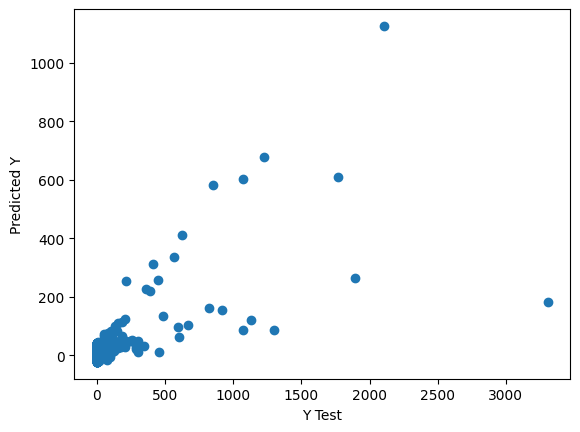

In [169]:
# Plot prediction vs the real result
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [170]:
# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2))
print('R2:', round(metrics.r2_score(y_test, predictions),2))

MAE: 18.22
MSE: 6080.77
RMSE: 77.98
R2: 0.35


In [171]:
temp_res = [{'Model':'Linear Model',
            'MAE': round(metrics.mean_absolute_error(y_test, predictions),2),
            'MSE' : round(metrics.mean_squared_error(y_test, predictions),2),
            'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2),
            'R2': round(metrics.r2_score(y_test, predictions),2)}]
Models_result = pd.DataFrame(temp_res)

In [172]:
# Create an instance for SGD
sgd = SGDRegressor()

# Fit the model in my training sets (X and y)
sgd.fit(X_train,y_train)

# Predict values for validation
predictions_sgd = sgd.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [173]:
# Print metrics: predictions_sgd
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_sgd),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_sgd),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_sgd)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_sgd),2))

MAE: 4.195904962470312e+26
MSE: 5.5493399198415345e+54
RMSE: 2.355703699500753e+27
R2: -5.939337736272445e+50


In [174]:
temp_res = [{'Model':'predictions_sgd',
            'MAE': round(metrics.mean_absolute_error(y_test, predictions_sgd),2),
            'MSE' : round(metrics.mean_squared_error(y_test, predictions_sgd),2),
            'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, predictions_sgd)),2),
            'R2': round(metrics.r2_score(y_test, predictions_sgd),2)}]
temp_res = pd.DataFrame(temp_res)

Models_result = pd.concat([Models_result,temp_res])
Models_result

,Model,MAE,MSE,RMSE,R2
0,Linear Model,1.822000e+01,6.080770e+03,7.798000e+01,3.500000e-01
0,predictions_sgd,4.195905e+26,5.549340e+54,2.355704e+27,-5.939338e+50


## Non-Linear Regression
Seems like my linear model didn't perform well. Let's try non-linear models to see if I can get an improvement on my predictions.

### Support Vector Machines (SVM)

In [175]:
# Instantiate the model to svm but as regression
svm_model = svm.SVR()

# Fit with my dataset
svm_model.fit(X_train,y_train)

# Predict values
predictions_svm = svm_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [176]:
# Print metrics: predictions_svm
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_svm),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_svm),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_svm)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_svm),2))

MAE: 9.59
MSE: 9433.27
RMSE: 97.13
R2: -0.01


In [177]:
temp_res = [{'Model':'SVM',
            'MAE': round(metrics.mean_absolute_error(y_test, predictions_svm),2),
            'MSE' : round(metrics.mean_squared_error(y_test, predictions_svm),2),
            'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, predictions_svm)),2),
            'R2': round(metrics.r2_score(y_test, predictions_svm),2)}]
temp_res = pd.DataFrame(temp_res)

Models_result = pd.concat([Models_result,temp_res])
Models_result

,Model,MAE,MSE,RMSE,R2
0,Linear Model,1.822000e+01,6.080770e+03,7.798000e+01,3.500000e-01
0,predictions_sgd,4.195905e+26,5.549340e+54,2.355704e+27,-5.939338e+50
0,SVM,9.590000e+00,9.433270e+03,9.713000e+01,-1.000000e-02


In [178]:
# Instantiate the model to svm but as regression
xg_boost_model = xgb.XGBRegressor(objective = 'reg:linear')

# Fit with my dataset
xg_boost_model.fit(X_train,y_train)

# Predict values
predictions_xgb = xg_boost_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:37:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [179]:
# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_xgb),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_xgb),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_xgb),2))

MAE: 70.1
MSE: 1931933.76
RMSE: 1389.94
R2: -205.77


In [180]:
temp_res = [{'Model':'XGB',
            'MAE': round(metrics.mean_absolute_error(y_test, predictions_xgb),2),
            'MSE' : round(metrics.mean_squared_error(y_test, predictions_xgb),2),
            'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb)),2),
            'R2': round(metrics.r2_score(y_test, predictions_xgb),2)}]
temp_res = pd.DataFrame(temp_res)

Models_result = pd.concat([Models_result,temp_res])
Models_result

,Model,MAE,MSE,RMSE,R2
0,Linear Model,1.822000e+01,6.080770e+03,7.798000e+01,3.500000e-01
0,predictions_sgd,4.195905e+26,5.549340e+54,2.355704e+27,-5.939338e+50
0,SVM,9.590000e+00,9.433270e+03,9.713000e+01,-1.000000e-02
0,XGB,7.010000e+01,1.931934e+06,1.389940e+03,-2.057700e+02


### Neural Networks

In [181]:
# Tensorlfow works with arrays, so transform my dataframe in array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [182]:
X_train.shape

(8798, 10)

In [183]:
# ANN
ann = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_shape=(10,), activation='relu'),
  tf.keras.layers.Dense(68, activation='relu'),
  tf.keras.layers.Dense(34, activation='relu'),
  tf.keras.layers.Dense(18, activation='relu'),
  tf.keras.layers.Dense(9, activation='relu'),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [184]:
# Compile and fit
opt = tf.keras.optimizers.Adam(0.001)
ann.compile(optimizer=opt, loss='mse')
r = ann.fit(X_train, y_train, epochs=100)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8006205049929728.0000
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 102932162805760.0000
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3787107860480.0000
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 44050532.0000
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 828416.4375
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 178564.0938
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 236108.1250
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2572506.7500
Epoch 9/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 385398400.0000
Epoch 10/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 996374347776.0000
Epoch 11/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1102533623808.0000
Epoch 12/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 367098303873024.0000
Epoch 13/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 89318

In [185]:
# Transform test dataframes into arrays
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Predict using ANN
predictions_ann = ann.predict(X_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [186]:
# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_ann),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_ann),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_ann)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_ann),2))

MAE: 48.94
MSE: 10673.66
RMSE: 103.31
R2: -0.14


In [187]:
temp_res = [{'Model':'ANN',
            'MAE': round(metrics.mean_absolute_error(y_test, predictions_ann),2),
            'MSE' : round(metrics.mean_squared_error(y_test, predictions_ann),2),
            'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, predictions_ann)),2),
            'R2': round(metrics.r2_score(y_test, predictions_ann),2)}]
temp_res = pd.DataFrame(temp_res)

Models_result = pd.concat([Models_result,temp_res])
Models_result

,Model,MAE,MSE,RMSE,R2
0,Linear Model,1.822000e+01,6.080770e+03,7.798000e+01,3.500000e-01
0,predictions_sgd,4.195905e+26,5.549340e+54,2.355704e+27,-5.939338e+50
0,SVM,9.590000e+00,9.433270e+03,9.713000e+01,-1.000000e-02
0,XGB,7.010000e+01,1.931934e+06,1.389940e+03,-2.057700e+02
0,ANN,4.894000e+01,1.067366e+04,1.033100e+02,-1.400000e-01


from matplotlib import pyplot as plt
_df_0['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MAE', y='MSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='MSE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='MSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [188]:
# RNN
# Input layer(
i = Input(shape=(10,1))

# build model using object i as input
layer = SimpleRNN(128, activation='relu')(i)
layer = Dense(64, activation='relu')(layer)
layer = Dense(12, activation='relu')(layer)
layer = Dense(6, activation='relu')(layer)
layer = Dense(1)(layer)

# Compile model
rnn = Model(i,layer)
rnn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Train the model
rnn_results = rnn.fit(X_train,y_train, epochs=100)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 134526999199744.0000
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4523303632896.0000
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1570403.0000
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2555801.2500
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1979846.2500
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2019012.0000
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 40821888.0000
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 15432246.0000
Epoch 9/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 248002944.0000
Epoch 10/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27659818.0000
Epoch 11/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 386833514496.0000
Epoch 12/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 810630643712.0000
Epoch 13/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9766350.0000
Epoch

In [189]:
# Predict using RNN
predictions_rnn = rnn.predict(X_test)

# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_rnn),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_rnn),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_rnn)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_rnn),2))

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 10.53
MSE: 9404.71
RMSE: 96.98
R2: -0.01


In [190]:
temp_res = [{'Model':'RNN',
            'MAE': round(metrics.mean_absolute_error(y_test, predictions_rnn),2),
            'MSE' : round(metrics.mean_squared_error(y_test, predictions_rnn),2),
            'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, predictions_rnn)),2),
            'R2': round(metrics.r2_score(y_test, predictions_rnn),2)}]
temp_res = pd.DataFrame(temp_res)

Models_result = pd.concat([Models_result,temp_res])
Models_result

,Model,MAE,MSE,RMSE,R2
0,Linear Model,1.822000e+01,6.080770e+03,7.798000e+01,3.500000e-01
0,predictions_sgd,4.195905e+26,5.549340e+54,2.355704e+27,-5.939338e+50
0,SVM,9.590000e+00,9.433270e+03,9.713000e+01,-1.000000e-02
0,XGB,7.010000e+01,1.931934e+06,1.389940e+03,-2.057700e+02
0,ANN,4.894000e+01,1.067366e+04,1.033100e+02,-1.400000e-01
0,RNN,1.053000e+01,9.404710e+03,9.698000e+01,-1.000000e-02


In [191]:
# LSTM
layer = LSTM(128)(i)
layer = Dense(64)(layer)
layer = Dense(12)(layer)
layer = Dense(6)(layer)
layer = Dense(1)(layer)

# Compile model
lstm = Model(i,layer)
lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Fit LSTM
lstm_result = lstm.fit(X_train,y_train, epochs=100)


Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 686699.1250
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 880354.9375
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 919011.4375
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 93354.6406
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 790513.5625
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 637574.0625
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 545366.5000
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 841025.7500
Epoch 9/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 173181.1562
Epoch 10/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 576552.7500
Epoch 11/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 709720.0625
Epoch 12/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 2772950.0000
Epoch 13/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 182841.6719
Epoch 14/100
275/275 ━━━━━━━━━━━━

In [192]:
# Predict using LSTM
predictions_lstm = lstm.predict(X_test)

# Print metrics
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions_lstm),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions_lstm),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions_lstm)),2))
print('R2:', round(metrics.r2_score(y_test, predictions_lstm),2))

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
MAE: 57.88
MSE: 12598.61
RMSE: 112.24
R2: -0.35


In [193]:
temp_res = [{'Model':'LSTM',
            'MAE': round(metrics.mean_absolute_error(y_test, predictions_lstm),2),
            'MSE' : round(metrics.mean_squared_error(y_test, predictions_lstm),2),
            'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, predictions_lstm)),2),
            'R2': round(metrics.r2_score(y_test, predictions_lstm),2)}]
temp_res = pd.DataFrame(temp_res)

Models_result = pd.concat([Models_result,temp_res])
Models_result

,Model,MAE,MSE,RMSE,R2
0,Linear Model,1.822000e+01,6.080770e+03,7.798000e+01,3.500000e-01
0,predictions_sgd,4.195905e+26,5.549340e+54,2.355704e+27,-5.939338e+50
0,SVM,9.590000e+00,9.433270e+03,9.713000e+01,-1.000000e-02
0,XGB,7.010000e+01,1.931934e+06,1.389940e+03,-2.057700e+02
0,ANN,4.894000e+01,1.067366e+04,1.033100e+02,-1.400000e-01
0,RNN,1.053000e+01,9.404710e+03,9.698000e+01,-1.000000e-02
0,LSTM,5.788000e+01,1.259861e+04,1.122400e+02,-3.500000e-01
